In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import os

mpl.rcParams['figure.figsize'] = 12, 8
mpl.rcParams['font.size'] = 18

### Regridding super high-resolution data

When I tried to use the method I just described to regrid the GMTED2010 topography dataset that WRF uses for its topography, I ran into problems. This topography is at 30-arcsecond resolution, so it has 43200x21600 data points, and the file is 2.7 GB

When I tried using xESMF to generate weights to go from this to the CESM grid, it ground to a halt. 

The underlying ESMF Fortran library can be used in parallel, but the python wrapper doesn't allow this option, due to complications from parallelizing python code. So, I needed to go back to the Fortran library

### Loading the data

Here I load the WRF topography and the CAM topography Marina used

In [2]:
mdir = '/glade/work/mduetsch/data/lgm_will'
pfile = 'PI_control/topo_regrid_corr_2deg_smooth_sgh30.nc'

ncp = os.path.join(mdir, pfile)

dsp = xr.open_dataset(ncp)
dsp

<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144)
Coordinates:
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    PHIS          (lat, lon) float64 ...
    SGH           (lat, lon) float64 ...
    LANDFRAC      (lat, lon) float64 ...
    LANDM_COSLAT  (lat, lon) float64 ...
    SGH30         (lat, lon) float64 ...
Attributes:
    history:            modified by mduetsch with add_SGH30_paleo on 200915
    make_ross:          false
    topofile:           topo_regrid_corr_10min.nc
    gridfile:           fv_1.9x2.5.nc
    landmask:           landm_coslat.nc
    sgh30_scaleFactor:  sgh30 = sgh*0.16 based on PD sgh30/sgh ratio.

In [3]:
ddir = '/glade/work/apauling/lgmoutput/topography'
wfile = 'gmted2010_modis-4regrid.nc'
ncw = os.path.join(ddir, wfile)
dsw = xr.open_dataset(ncw)
dsw

<xarray.Dataset>
Dimensions:    (lat: 3600, lon: 43200)
Coordinates:
  * lat        (lat) float64 -90.0 -89.99 -89.98 -89.97 ... -60.02 -60.01 -60.0
  * lon        (lon) float64 0.004028 0.01236 0.02069 ... 360.0 360.0 360.0
Data variables:
    htopo      (lat, lon) int16 ...
    landfract  (lat, lon) int8 ...
Attributes:
    source:   USGS 30-sec dataset GTOPO30
    title:    30-second USGS topo data
    history:  Written on date: 20210203

### Using the generated weights

Once the weights had been generated, I could read them in by specifying the filename and `reuse_weights` options to the Regridder object:

In [4]:
wgts = '/glade/work/apauling/lgmoutput/topography/weights_2deg_to_WRF.nc'

regridder = xe.Regridder(dsp, dsw,
                         method='bilinear',
                         periodic=True,
                         filename=wgts,
                         weights=wgts,
                         reuse_weights=True)
regridder

/glade/u/home/apauling/miniconda3/envs/xesmf_env/lib/python3.8/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            /glade/work/apauling/lgmoutput/topography/weights_2deg_to_WRF.nc 
Reuse pre-computed weights? True 
Input grid shape:           (96, 144) 
Output grid shape:          (3600, 43200) 
Periodic in longitude?      True

In [5]:
topo_native = dsp['PHIS']/9.80616
topo_regrid = regridder(topo_native).rename('htopo')
topo_regrid

/glade/u/home/apauling/miniconda3/envs/xesmf_env/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


<xarray.DataArray 'htopo' (lat: 3600, lon: 43200)>
array([[2719.47750347, 2719.47757054, 2719.4776376 , ..., 2719.47730277,
        2719.47736964, 2719.47743651],
       [2719.50366146, 2719.50386728, 2719.50407308, ..., 2719.50304551,
        2719.50325073, 2719.50345596],
       [2719.52981933, 2719.53016389, 2719.53050846, ..., 2719.52878813,
        2719.52913171, 2719.52947528],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])
Coordinates:
  * lon      (lon) float64 0.004028 0.01236 0.02069 ... 360.0 360.0 360.0
  * lat      (lat) float64 -90.0 -89.99 -89.98 -89.97 ... -60.02 -60.01 -60.0
Attributes:
    regrid_method:  bilinear

In [8]:
def plotstereo(fig, axnum, data, title):
    axs = fig.add_subplot(1, 2, axnum, projection=ccrs.SouthPolarStereo())
    axs.coastlines()
    axs.gridlines()
    axs.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
    im = data.plot.imshow('lon', 'lat', ax=axs, transform=ccrs.PlateCarree(),
                         cmap='terrain')
    axs.set_title(title)
    im.set_clim(0, 4000)
    
    return im, axs

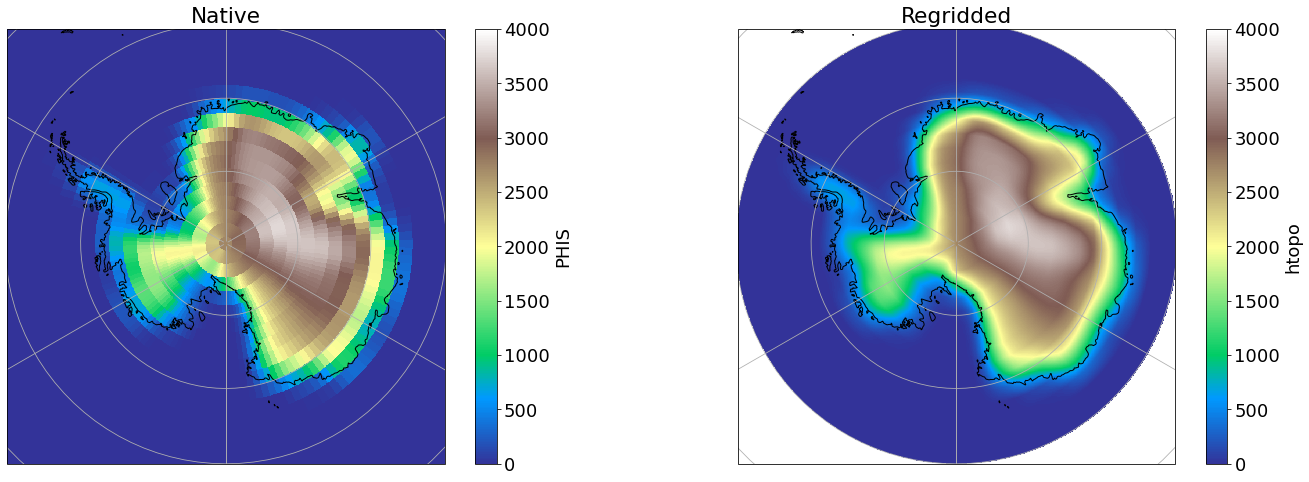

In [9]:
fig = plt.figure(figsize=(24, 8))
im1, ax1 = plotstereo(fig, 1, topo_native, 'Native')
im2, ax2 = plotstereo(fig, 2, topo_regrid, 'Regridded')